Osnabrück University - Computer Vision (Winter Term 2021/22) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before **14:00 of Tuesday, December 7, 2021**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

YOUR ANSWER HERE

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

YOUR ANSWER HERE

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

YOUR ANSWER HERE

## Assignment 1: Edge-based segmentation  [5 Points]

### a) Gradients
What is the gradient of a pixel? How do we calculate the first, how the second derivative of an image?  

The gradient of the pixel is the change of intensity or color, compared to its neighboring pixels in a specific direction. The derivative of an image is computed by filtering the image with a small filter, i.e. a laplacian filter. 

### b) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

In edge linking an edge is created pixel by pixel. The algorithm tries to find pixels in the neighborhood of an edge pixel, which are perpendicular to the edge pixels gradient and mark them also as edge pixels.

### c) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

Zero crossings are values of the 2nd derivative of an image where the derivative crosses the zero value (goes from positive to negative or from negative to positive). They lead to closed contours because zero crossing mark the borders from "valleys" to "hills".

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

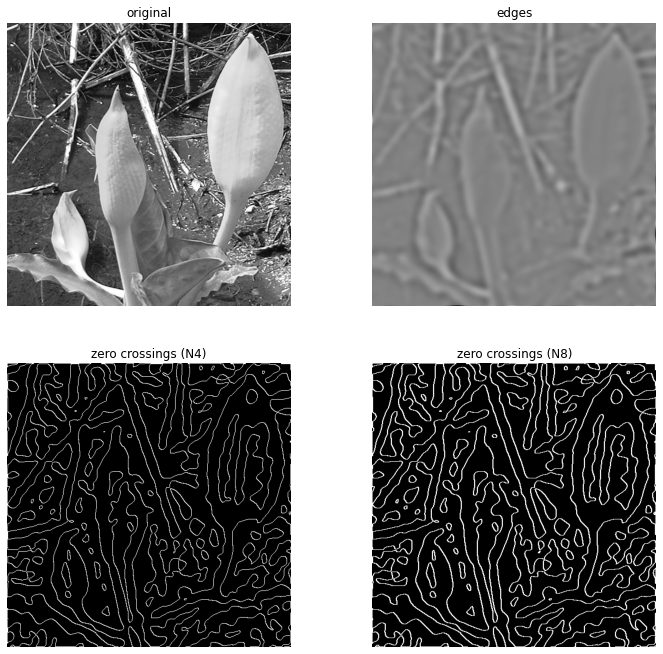

In [35]:
from skimage import filters
from skimage.feature import canny
from skimage.color import rgb2gray
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
%matplotlib inline

img = imread('images/swampflower.png').astype(float)
#img = imread('images/peppers.png').astype(float)

if len(img.shape)>2:
    img = rgb2gray(img)
img /= img.max()

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
# YOUR CODE HERE
##### smooth image #####
sigma = 7
smoothed_img = filters.gaussian(img, sigma)

###### edges ######
# compute edge image with a laplacian filter
edges = filters.laplace(smoothed_img)

###### shift image - function ######
# shift the image in a given x-y-direction, fill the gaps with ones
def shift_image(img, y_offset, x_offset):
    s_img = img.copy()
    
    shifted_img = np.ones(img.shape)
    
    for y in range(s_img.shape[0]):
        for x in range(s_img.shape[1]):
            if y + y_offset < 0 or x + x_offset < 0 or y + y_offset >= s_img.shape[0] or x + x_offset >= s_img.shape[1]:
                continue
            shifted_img[y + y_offset][x + x_offset] = s_img[y][x]
    return shifted_img
            

##### zero crossings for n4 #####
shifts = [[1,0], [0,1]]

shifted_images = []

for op in shifts:
    shifted_images.append(shift_image(edges, op[0], op[1]))

# compute the zero crossings
zero_crossings_n4 = np.zeros(img.shape)

for sf in shifted_images:
    for y in range(sf.shape[0]):
        for x in range(sf.shape[1]):
            if edges[y][x] * sf[y][x] <= 0:
                zero_crossings_n4[y][x] = 1

                
                
##### zero crossings for n8 #####
shifts = [[1,0], [0,1], [1, -1], [1, 1]]

shifted_images = []

for op in shifts:
    shifted_images.append(shift_image(edges, op[0], op[1]))

# compute the zero crossings
zero_crossings_n8 = np.zeros(img.shape)

for sf in shifted_images:
    for y in range(sf.shape[0]):
        for x in range(sf.shape[1]):
            if edges[y][x] * sf[y][x] <= 0:
                zero_crossings_n8[y][x] = 1

                
plt.figure(figsize=(12, 24))
plt.gray()

plt.subplot(4,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(4,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(4,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(4,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )
#plt.subplot(4,2,5); plt.axis('off'); plt.imshow(grad_mag); plt.title('Gradient Magnitude' )
#plt.subplot(4,2,6); plt.hist(grad_mag.flatten(), 255, (0, grad_mag.max())); plt.title('Histogram Gradient Magnitude' )
#plt.subplot(4,2,7); plt.axis('off'); plt.imshow(zero_crossings_n8_thresh); plt.title('zero crossings (N8) Thresh' )
#plt.subplot(4,2,8); plt.axis('off'); plt.imshow(canny(img,sigma=2)); plt.title('Canny')
plt.show()

## Assignment 2: Watershed transform  [5 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



At first the gradient image of an image is taken. Then the "landscape" of this gradient image is flooded with water. At first the water is only in the valleys but as it begins to rise, some waters might touch each other. That is where both segments end.

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildin functions for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import segmentation
%matplotlib inline


def get_neighbors_n8(img, y, x):
    list = []
    
    if x - 1 >= 0:
        list.append(img[y][x-1])
                            
    if x + 1 < img.shape[1]:
        list.append(img[y][x+1])
                        
    if y - 1 >= 0:
        list.append(img[y-1][x])
                    
    if y + 1 < img.shape[0]:
        list.append(img[y+1][x])
        
    if y-1 >= 0 and x-1 >= 0:
        list.append(img[y-1][x-1])
        
    if y-1 >= 0 and x+1 < img.shape[1]:
        list.append(img[y-1][x+1])
        
    if y+1 < img.shape[0] and x-1 >= 0:
        list.append(img[y+1][x-1])
        
    if y+1 < img.shape[0] and x+1 < img.shape[1]:
        list.append(img[y+1][x+1])
    
    return list
        
    
    
    
def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img (ndarray): The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        edges (ndarray): A binary image containing the watersheds.
    """

    NO_LABEL = 0
    WATERSHED = 1
    new_label = 2

    # initialize labels
    label = np.zeros(img.shape, np.uint16)

    # YOUR CODE HERE
    h = 0
    max = img.max()
    
    neigh_queue = []
    
    while h <= max:
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                if h >= img[row][col] and label[row][col] == NO_LABEL:
                    
                    # Whenever a label is assigned, its' neighboring pixels are added to neigh_queue
                    neigh_queue.append((row,col))
                    
                    while(neigh_queue):
                        y, x = neigh_queue.pop(0)
                        # Continue, if label is assigned or pixel is > h
                        if h < img[y][x] or label[y][x] != NO_LABEL:
                            continue
                        
                        neighbors = get_neighbors_n8(label, y, x)
                        
                        # Case 1: No neighbor has a label
                        all_zero = True
                        # Check if every neighbor has no label
                        for lab in neighbors:
                            if lab != NO_LABEL:
                                all_zero = False

                        # If every neighbor has no label, assign a new label and add neighbors to the queue
                        if all_zero:

                            label[y][x] = new_label
                            
                            if y-1 >= 0:
                                neigh_queue.append((y-1,x))
                            if y+1 < img.shape[0]:
                                neigh_queue.append((y+1,x))
                            if x-1 >= 0:
                                neigh_queue.append((y,x-1))
                            if x+1 < img.shape[1]:
                                neigh_queue.append((y,x+1))
                            
                            new_label += 1
                            continue
                        
                        
                        # Case 2: Neighbors have identical labels
                        identical_labels = True
                        
                        # Check if all labels are the same
                        curr_label = NO_LABEL

                        for i in range(len(neighbors)):
                            if neighbors[i] == NO_LABEL or neighbors[i] == WATERSHED:
                                continue
                            if curr_label == NO_LABEL: 
                                curr_label = neighbors[i]
                            elif curr_label != neighbors[i]:
                                identical_labels = False
                                
                        # If all labels are identical, assign this label and add neighbors to queue
                        if identical_labels:
                            if y-1 >= 0:
                                neigh_queue.append((y-1,x))
                            if y+1 < img.shape[0]:
                                neigh_queue.append((y+1,x))
                            if x-1 >= 0:
                                neigh_queue.append((y,x-1))
                            if x+1 < img.shape[1]:
                                neigh_queue.append((y,x+1))
                            
                            label[y][x] = curr_label
                            continue
                        
                        # If labels are different, assign watershed
                        if not identical_labels:
                            
                            label[y][x] = WATERSHED
                        
        h += step
        
    edges = np.zeros(img.shape)
    
    for y in range(edges.shape[0]):
        for x in range(edges.shape[1]):
            if label[y][x] == 1:
                edges[y][x] = 1

    return label, edges
                

img = imageio.imread('images/dist_circles.png', pilmode='L')

labels, ws = watershed(img)

plt.gray()
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img)

plt.gray()
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(labels)

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(ws)
plt.show()

FileNotFoundError: No such file: 'C:\Users\tills\Desktop\computer_vision\abgabe\images\dist_circles.png'

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.
You can use build-in functions instead of your own watershed function.

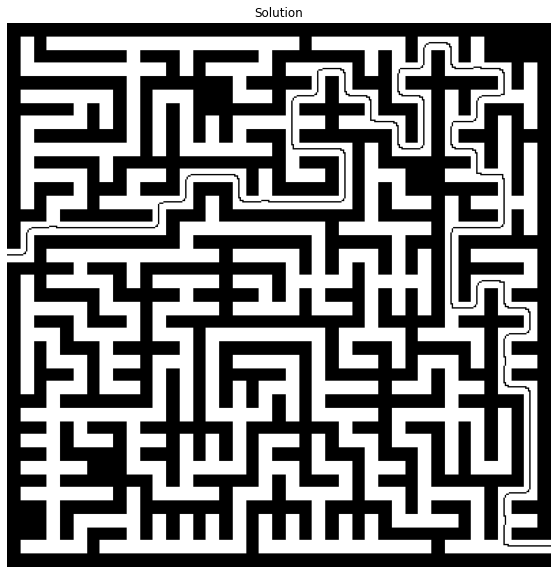

In [12]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from skimage import segmentation
%matplotlib inline

img = imageio.imread('images/maze2.png', pilmode = 'L') # 'maze1.png' or 'maze2.png'

result = img[:, :, np.newaxis].repeat(3, 2)
# YOUR CODE HERE
dt = distance_transform_edt(img)
ws = segmentation.watershed(dt)

for y in range(ws.shape[0]):
    for x in range(ws.shape[1]):
        if x+1 < ws.shape[1]:
            if ws[x][y] != ws[x+1][y]:
                result[x][y] = 1
                
        if y+1 < ws.shape[0]:
            if ws[x][y] != ws[x][y+1]:
                result[x][y] = 1

plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(result)
plt.show()

By flooding the distance transform of the maze, two different segments are created. The way through the maze is the border between these two segments so it consists of the watersheds after flooding the maze.

## Assignment 3: $k$-means segmentation [5 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

YOUR ANSWER HERE

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.cdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector. (Empirically) determine a good value for $k$ for clustering the image 'peppers.png'.
**Bonus** If you want you can visualize the intermediate steps of the clustering process.

First lets take a look at how our image looks in RGB colorspace. 

<IPython.core.display.Javascript object>


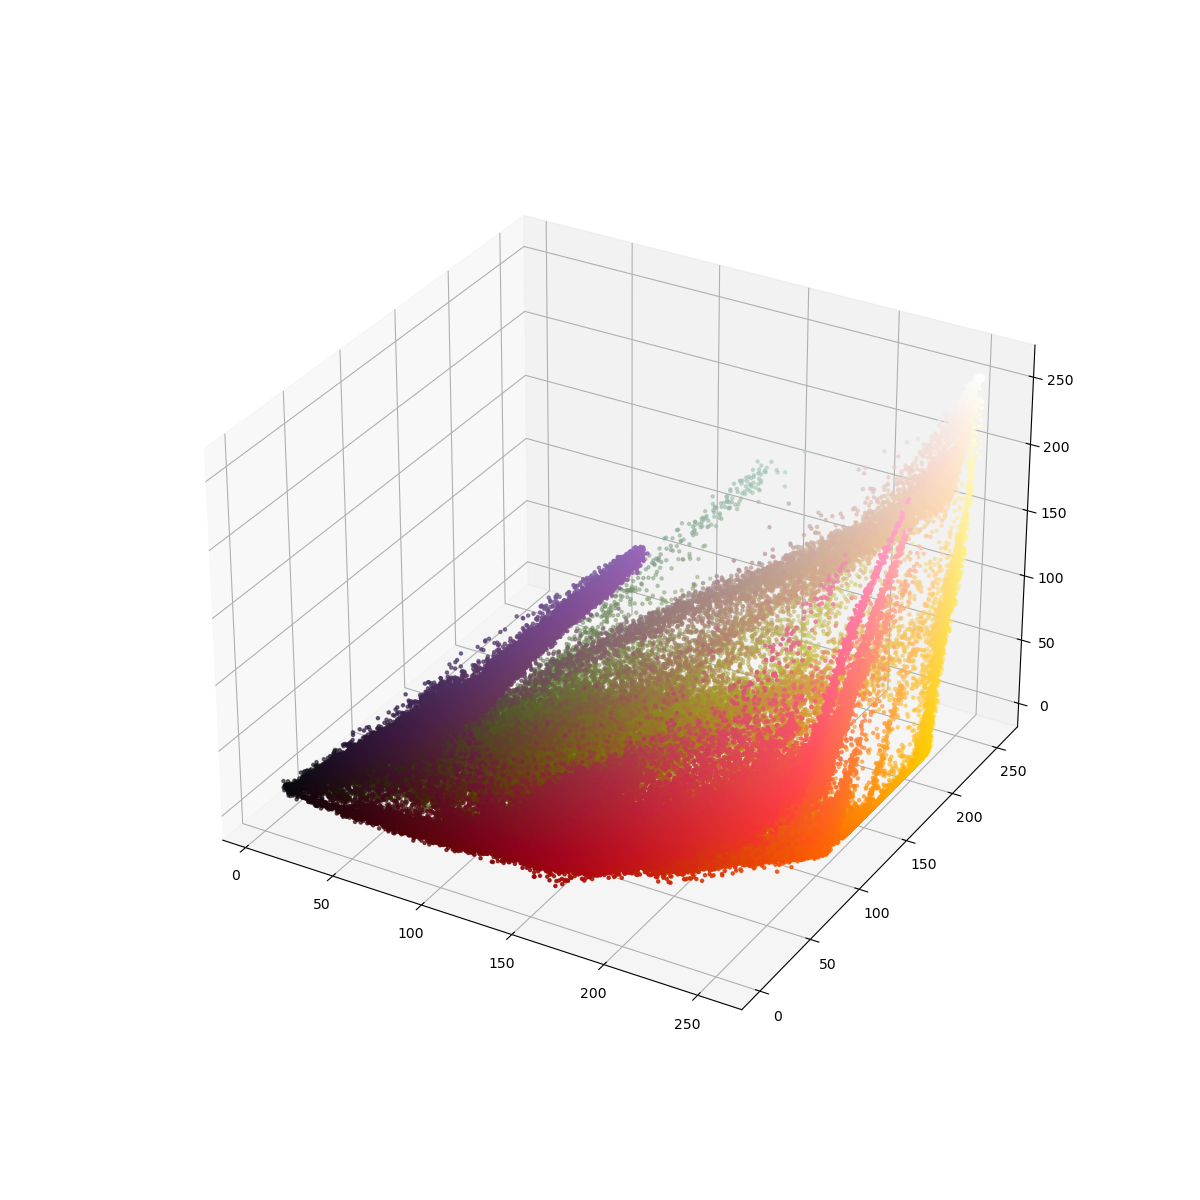

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib notebook

img = imread('images/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

##################################################
calculating clusters with k=2..

new cycle..


100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:10<00:00, 36.78it/s]


max_dist ([[113.1280676]]) is above threshold.. continuing..
new cycle..


100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:11<00:00, 33.92it/s]


max_dist ([[15.26536337]]) is above threshold.. continuing..
new cycle..


100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:11<00:00, 35.28it/s]


max_dist ([[5.17425067]]) is below threshold.. finishing..


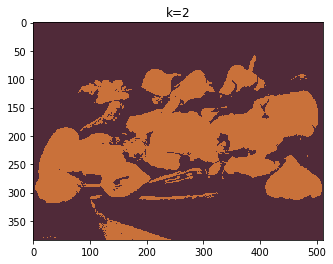

##################################################
calculating clusters with k=3..

new cycle..


100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:15<00:00, 24.35it/s]


max_dist ([[93.74667747]]) is above threshold.. continuing..
new cycle..


 39%|███████████████████████████████▎                                                | 150/384 [00:06<00:10, 23.04it/s]


KeyboardInterrupt: 

In [1]:
import numpy as np
from scipy.spatial import distance
from IPython import display
from imageio import imread
import time
import matplotlib.pyplot as plt
import math
%matplotlib inline

from tqdm import tqdm

def kmeans_rgb(img, k, threshold=0, do_display=None):
    """
    k-means clustering in RGB space.

    Args:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): 'number of clusters' x 3 array. 
            RGB color for each cluster center.
    """
    
    # do some information output
    print("#"*50)
    print("calculating clusters with k={}..\n".format(k))
    
    # initialize cluster
    cluster = np.zeros(img.shape)
    
    # initialize centers
    centers = dict()
    
    # create k random centroids
    for i in range(k):
        rgb_values = np.random.randint(0, 256, 3)  # creates 3 values in range 0-256
        centers[i] = rgb_values

    # as long as cluster changes (pixels get assigned to new clusters), the algorithm is not finished
    centers_pos_changed = True
    centers_copy = centers.copy()  # initial setup before while loop
    while centers_pos_changed:
        print("new cycle..")
        centers_copy = centers.copy()
        
        # reinitialize center if cluster is empty
        for cent_index, center_position in centers.items():
            if len(center_position) == 0:
                print("cluster {} was empty.. reinitializing..".format(cent_index))
                rgb_values = np.random.randint(0, 256, 3)
                center[cent_index] = rgb_values
        
        # fixes tqdm line bug with jupyter notebook
        #while len(tqdm._instances) > 0:
        #    tqdm._instances.pop().close()
        
        # do loop through pixels, calculate distance to every centroid and assign; create bool if changes happened
        for row in tqdm(range(img.shape[0])):
            for col in range(img.shape[1]):

                # get pixel values
                r_val = img[row, col, 0]
                g_val = img[row, col, 1]
                b_val = img[row, col, 2]

                # calculate distance
                min_dist = 500  # arbitrary number to set first element in upcoming loop as min_dist
                centr_min_dist = None
                for cent_index, cent_arr in centers.items():
                    dist = distance.cdist([(r_val, g_val, b_val)], [(cent_arr[0], cent_arr[1], cent_arr[2])])

                    # check if dist is lowest
                    if dist < min_dist:
                        min_dist = dist
                        centr_min_dist = cent_index

                # assign centroid label to pixel
                cluster[row, col, :] = centr_min_dist

        # calculate new mean based on values of pixels in the clusters
        for cent_index, _ in centers.items():

            r_cent_values = list()
            g_cent_values = list()
            b_cent_values = list()
            for row in range(img.shape[0]):
                for col in range(img.shape[1]):
                    if cluster[row, col, 0] == cent_index:
                        r_cent_values.append(img[row, col, 0])
                        g_cent_values.append(img[row, col, 1])
                        b_cent_values.append(img[row, col, 2])

            r_mean_centroid = np.mean(r_cent_values)
            g_mean_centroid = np.mean(g_cent_values)
            b_mean_centroid = np.mean(b_cent_values)

            # update dictionary on new clustering seed positions
            centers[cent_index] = [r_mean_centroid, g_mean_centroid, b_mean_centroid]
            
        # check if centers moved more than the predefined threshold
        distances = list()
        for i in range(k):
            centers_values = list(centers.values())[i]
            centers_copy_values = list(centers_copy.values())[i]
            dist = distance.cdist([(centers_copy_values[0], centers_copy_values[1], centers_copy_values[2])],
                                  [(centers_values[0], centers_values[1], centers_values[2])])
            distances.append(dist)
        
        # get maximum distance change of all centers and check if threshold is broken
        max_dist = max(distances)
        if max_dist <= threshold:
            print("max_dist ({}) is below threshold.. finishing..".format(max_dist))
            centers_pos_changed = False
        else:
            print("max_dist ({}) is above threshold.. continuing..".format(max_dist))
            centers_pos_changed = True
            
    return cluster, centers



def transform_cluster_to_img(cluster, centers):
    """ transform labels in cluster to corresponding rgb-values given in centers 
    
    Parameters
    ----------
    cluster: ndarray
        contains labels of cluster
    centers: dict
        contains mean position (value) to every cluster (key)
        
    Returns
    -------
    img: ndarray
        image with rbg values of mean positions depending on cluster the pixel belongs to
    """
    
    img = np.zeros(cluster.shape)
    for row in range(cluster.shape[0]):
        for col in range(cluster.shape[1]):
            for cent_index, cent_position in centers.items():
                if cluster[row, col, 0] == cent_index:
                    img[row, col, 0] = cent_position[0]
                    img[row, col, 1] = cent_position[1]
                    img[row, col, 2] = cent_position[2]
    return img

img = imread('images/peppers.png')

# try different k's for empirical comparison of different cluster amounts
for k in range(2, 8):
    cluster, centers = kmeans_rgb(img, k=k, threshold=10, do_display=False)
    img_trans = transform_cluster_to_img(cluster, centers)
    plt.title("k={}".format(k))
    plt.imshow(img_trans.astype('uint8'))
    plt.show()

**c)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

*NOTE:*
All the information about the color is only present in the first dimension. The color is given in the hue, the saturation and the value do not influence the color segmentation of the k-clustering, therefore the result can be improved by reducing the HSV space to the first dimension. <br>
The code is similar to the one given in b), except that the dimension is reduced to the first one and the value range is increase from [0, 1] to [0, 255] for visulation later on.

##################################################
calculating clusters with k=2..

new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:02<00:00, 158.81it/s]


max_dist ([21.4510842]) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 830.41it/s]


max_dist (0.06080606711520886) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 839.48it/s]


max_dist (0.0) is below threshold.. finishing..


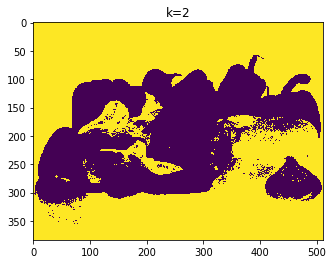

##################################################
calculating clusters with k=3..

new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:03<00:00, 112.41it/s]


max_dist ([37.12957009]) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 688.78it/s]


max_dist (15.615406575784945) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 719.78it/s]


max_dist (20.485579642331132) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 742.06it/s]


max_dist (16.567859365276377) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 685.08it/s]


max_dist (8.593771144645473) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 730.41it/s]


max_dist (4.513899413673748) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 688.77it/s]


max_dist (2.3688504078497985) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 729.36it/s]


max_dist (1.3171661266921237) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 726.60it/s]


max_dist (0.6707336467835336) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 733.55it/s]


max_dist (0.33699144653318136) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 701.36it/s]


max_dist (0.17415940221135173) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 740.60it/s]


max_dist (0.0722273732600307) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 714.40it/s]


max_dist (0.02676214405884636) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 739.20it/s]


max_dist (0.009317752662500567) is below threshold.. finishing..


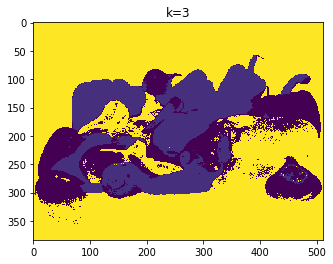

##################################################
calculating clusters with k=4..

new cycle..


100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:04<00:00, 95.82it/s]


max_dist ([82.98144453]) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 642.63it/s]


max_dist (12.176392757269241) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 632.03it/s]


max_dist (7.169146451707633) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 667.02it/s]


max_dist (1.7397845164220769) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 650.33it/s]


max_dist (1.0879317750467976) is above threshold.. continuing..
new cycle..


100%|███████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 661.07it/s]


max_dist (0.9787696709530849) is above threshold.. continuing..
new cycle..


 69%|██████████████████████████████████████████████████████▌                        | 265/384 [00:00<00:00, 653.83it/s]


KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import color
from imageio import imread
%matplotlib inline
# from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from tqdm import tqdm

img = imread('images/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold = 0):
    """
    k-means clustering in HSV space.

    Args:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    
    # do some information output
    print("#"*50)
    print("calculating clusters with k={}..\n".format(k))
    
    # initialize cluster
    cluster = np.zeros(img.shape)
    
    # initialize centers
    centers = dict()
    
    # create k random centroids
    for i in range(k):
        rgb_values = np.random.randint(0, 256, 1)  # creates 1 value in range 0-256
        centers[i] = rgb_values

    # as long as cluster changes (pixels get assigned to new clusters), the algorithm is not finished
    centers_pos_changed = True
    centers_copy = centers.copy()  # initial setup before while loop
    while centers_pos_changed:
        print("new cycle..")
        centers_copy = centers.copy()
        
        # reinitialize center if cluster is empty
        for cent_index, center_position in centers.items():
            if not bool(center_position):
                print("cluster {} was empty.. reinitializing..".format(cent_index))
                rgb_values = np.random.randint(0, 256, 1)
                center[cent_index] = rgb_values
        
        # fixes tqdm line bug with jupyter notebook
        #while len(tqdm._instances) > 0:
        #    tqdm._instances.pop().close()
        
        # do loop through pixels, calculate distance to every centroid and assign; create bool if changes happened
        for row in tqdm(range(img.shape[0])):
            for col in range(img.shape[1]):

                # get pixel values
                pix_val = img[row, col, 0]

                # calculate distance
                min_dist = 500  # arbitrary number to set first element in upcoming loop as min_dist
                centr_min_dist = None
                for cent_index, cent_val in centers.items():
                    dist = abs(pix_val - cent_val)

                    # check if dist is lowest
                    if dist < min_dist:
                        min_dist = dist
                        centr_min_dist = cent_index

                # assign centroid label to pixel
                cluster[row, col, :] = centr_min_dist

        # calculate new mean based on values of pixels in the clusters
        for cent_index, _ in centers.items():

            pix_cent_values = list()
            for row in range(img.shape[0]):
                for col in range(img.shape[1]):
                    if cluster[row, col, 0] == cent_index:
                        pix_cent_values.append(img[row, col, 0])

            pix_mean_centroid = np.mean(pix_cent_values)

            # update dictionary on new clustering seed positions
            centers[cent_index] = pix_mean_centroid
            
        # check if centers moved more than the predefined threshold
        distances = list()
        for i in range(k):
            centers_values = list(centers.values())[i]
            centers_copy_values = list(centers_copy.values())[i]
            dist = abs(centers_copy_values - centers_values)
            distances.append(dist)
        
        # get maximum distance change of all centers and check if threshold is broken
        max_dist = max(distances)
        if max_dist <= threshold:
            print("max_dist ({}) is below threshold.. finishing..".format(max_dist))
            centers_pos_changed = False
        else:
            print("max_dist ({}) is above threshold.. continuing..".format(max_dist))
            centers_pos_changed = True
            
    return cluster, centers

def transform_cluster_to_img(cluster, centers):
    """ transform labels in cluster to corresponding rgb-values given in centers 
    
    Parameters
    ----------
    cluster: ndarray
        contains labels of cluster
    centers: dict
        contains mean position (value) to every cluster (key)
        
    Returns
    -------
    img: ndarray
        image with rbg values of mean positions depending on cluster the pixel belongs to
    """
    
    img = np.zeros(cluster.shape)
    for row in range(cluster.shape[0]):
        for col in range(cluster.shape[1]):
            for cent_index, cent_position in centers.items():
                if cluster[row, col, 0] == cent_index:
                    img[row, col, 0] = cent_position

    return img

img_hsv = color.rgb2hsv(img)
img_hsv = img_hsv * 256
k = 7
theta = 0.01

# try different k's for empirical comparison of different cluster amounts
for k in range(2, 8):
    cluster, centers_hsv = kmeans_hsv(img_hsv[:,:,:], k, theta)
    img_trans = transform_cluster_to_img(cluster, centers_hsv)
    plt.title("k={}".format(k))
    plt.imshow(img_trans[:, :, 0])
    plt.show()

## Assignment 4: Interactive Region Growing [5 Points]

Implement flood fill as described in (CV07 slides 123ff.).

In a recursive implementation the floodfill function is called for the seed pixel. In the function a recursive call for the four neighbouring pixels is made, if the color of the pixel, the function is called with, is similar to the seed color. If this is the case the pixel is added to the region. [Other](https://en.wikipedia.org/wiki/Flood_fill) more elegant solutions exist aswell.

The function `on_press` is called when a mouse button is pressed inside the canvas. From there call `floodfill`. Use the filtered hsv image `img_filtered` for your computation, and show the computed region around the seed point (the position where the mousebutton was pressed) in the original image. You may use a mask to save which pixels belong the the region (and to save which pixels you already visited). 

Hint: If you can not see the image, try restarting the kernel.

<IPython.core.display.Javascript object>


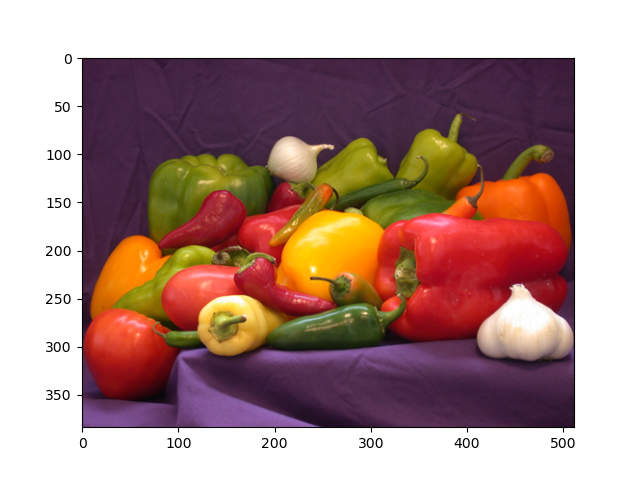

In [1]:
%matplotlib notebook
import imageio
import math
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
import scipy.ndimage as ndimage
from sys import setrecursionlimit

threshold = .08;   # standard .08

setrecursionlimit(100000)   # standard 100000

def floodfill(img, mask, x, y, color, region):
    """Recursively grows region around seed point
    
    Args: 
        img (ndarray): The image in which the region is grown
        mask (boolean ndarray): Visited pixels which belong to the region.
        x (uint): X coordinate of the pixel. Checks if this pixels belongs to the region
        y (uint): Y coordinate of the pixel.
        color (list): The color at the seed position
    """
    # YOUR CODE HERE
    
    if x < 0 or y < 0 or x >= img.shape[1] or y >= img.shape[0]:
        return
    
    if mask[y][x]:     
        return
   
    if abs(img[y][x][0] - color[0]) <= threshold and abs(img[y][x][1] - color[1]) <= threshold and abs(img[y][x][2] - color[2]) <= threshold:
        
        region[y][x] = True
        mask[y][x] = True
        
        floodfill(img, mask, x+1, y, color, region)
        floodfill(img, mask, x-1, y, color, region)
        floodfill(img, mask, x, y+1, color, region)
        floodfill(img, mask, x, y-1, color, region)
        
def on_press(event):
    """Mouse button press event handler
    
    Args:
        event: The mouse event
    """
    x = math.floor(event.xdata)
    y = math.floor(event.ydata)
    color = img_filtered[x, y, :]

    # YOUR CODE HERE
    fill_from_pixel(img, img_filtered, x, y)
    
    plt.imshow(img)
    fig.canvas.draw()
    

def fill_from_pixel(img, img_filtered, x,y):
    """ Calls floodfill from a pixel position
    
    Args:
        img (ndarray): IO image on which fill is drawn.
        img_filtered (ndarray): Processing image on which floodfill is computed.
        x (uint): Coordinates of pixel position.
        y (uint): Coordinates of pixel position.

    Returns:
        img (ndarray): Image with grown area in white
    """
    mask = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    region = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    color = img_filtered[y,x, :]
    floodfill(img_filtered, mask, x, y, color, region)
    img[region] = (255,255,255)
    
    return img


img = imageio.imread('images/peppers.png')
img_hsv = color.rgb2hsv(img)
img_filtered = ndimage.median_filter(img_hsv, 5)
#img = fill_from_pixel(img, img_filtered, 200, 300) # Comment in to deactivate simple testing at fixed position
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img)

fig.canvas.mpl_connect('button_press_event', on_press)

plt.show()